<a href="https://colab.research.google.com/github/crdsteixeira/OR_project/blob/main/Scheduling_Aircraft_Landings_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the library

In [1]:
# !pip install docplex
# !pip install cplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 KB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.24.232-py3-none-any.whl size=682306 sha256=3ee9eebea53ecf32245b652bcdf1ab7642355b881fbb44656c4ddeb5cb07c7be
  Stored in directory: /root/.cache/pip/wheels/cd/84/5d/b9c307d9cf361c49d41ddea36761e226bba3afdfd038673dcd
Successfully built docplex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 19.8 MB/s eta 0:00:00


In [243]:
from docplex.cp.model import *
import numpy as np

# Info

The format of these data files is:
number of planes (p), freeze time
for each plane i (i=1,...,p):
   - appearance time, 
   - earliest landing time, 
   - target landing time,
   - latest landing time, 
   - penalty cost per unit of time for landing before target, 
   - penalty cost per unit of time for landing after target

for each plane j (j=1,...p): separation time required after 
                                i lands before j can land


### Sigle runway definitions and variables

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/single_run.png?raw=1)


### Multirunway defintions and variables 

![image.png](https://github.com/crdsteixeira/OR_project/blob/main/Images/multi_run.png?raw=1)

## Get data

In [244]:
def read_datafiles(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=float)
        separation_time = np.empty([0,number_planes],dtype=float)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0
                
#         print(f" number planes: {number_planes}")
#         print(f" freeze time: {freeze_time}")
#         print(f" mixed data: {mixed_data}")
#         print(f" flight details: {flight_details}")
#         print(f" separation time: {separation_time}")
    
    return number_planes, freeze_time, flight_details, separation_time


In [7]:
read_datafiles("./Data/airland1.txt")

(10, 10, array([[ 54., 129., 155., 559.,  10.,  10.],
        [120., 195., 258., 744.,  10.,  10.],
        [ 14.,  89.,  98., 510.,  30.,  30.],
        [ 21.,  96., 106., 521.,  30.,  30.],
        [ 35., 110., 123., 555.,  30.,  30.],
        [ 45., 120., 135., 576.,  30.,  30.],
        [ 49., 124., 138., 577.,  30.,  30.],
        [ 51., 126., 140., 573.,  30.,  30.],
        [ 60., 135., 150., 591.,  30.,  30.],
        [ 85., 160., 180., 657.,  30.,  30.]]), array([[9.9999e+04, 3.0000e+00, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [3.0000e+00, 9.9999e+04, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [1.5000e+01, 1.5000e+01, 9.9999e+04, 8.0000e+00, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [1.5000e+01, 1.5000e+01, 8.0000e+00, 9.9999e+04, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 

# The MIP model

In [245]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display
import matplotlib.pyplot as plt

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.All)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
#         self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        super(MipGapPlotter, self).notify_start()
        self.times =[]
        self.gaps = []
#         self.lines, = self.ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
#         display.clear_output(wait=True)
        print(f"gap:. {gap}")
        plt.plot(self.times, self.gaps)
#         display.display(plt.gcf())
        

In [248]:
def MIP_model(file_name,R):
    from docplex.mp.model import Model
    mdl = Model("Scheduling Aircraft Landing - Multi Runway Static Case")
    
    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)
    
    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables

    E = flight_details[:,1]  #earliest landing time,
    T = flight_details[:,2]  #target landing time,
    L = flight_details[:,3]  #latest landing time,
    g = flight_details[:,4]  #penalty cost per unit of time for landing before target,
    h = flight_details[:,5]  #penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1]) #landing range time

    s = separation_time      # here we consider separation time between planes that land in different runways, fundamentally their value is the same as the separation time matrix but in constraints it should be multiplied by the binary variable that says if the planes land in the same runway or not

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)] # indexes for plane i and j landing in the same runway
    ir = [(i, r) for i in np.arange(P) for r in np.arange(R)] # indexes for plane i landing in runway r

#     # Creating the time spaces
#     W = []
#     V = []
#     U = []
#     for i in range(P):
#         for j in range(P):
#             if i != j:
#                 min_range_i, min_range_j, max_range_i, max_range_j = E[i], E[j], L[i], L[j]
#                 land_range_i = [min_range_i, max_range_i]
#                 land_range_j = [min_range_j, max_range_j]

#                 overlap = max(0, min(land_range_i[1], land_range_j[1]) - max(land_range_i[0], land_range_j[0])) #Check if landing intervals overlap

#           # To confirm if the separation time window is safe we should see if latest landing time of plane i plus the separation time  
#           # between plane i and j is lower and then the earliest landing time for plane j

#           # This way we are also confirming that i lands before j

#                 if (overlap == 0) and ((L[i] + separation_time[i,j]) < E[j]): # confirm that the windows don't intersept and separation time is big enough
#                   W.append((i,j))
#                 else:
#                     if (L[i] < E[j]): # windows intersept but we know that i lands before j
#                         V.append((i,j))
#                     else: 
#                         U.append((i,j)) # we don't know the order in which one lands
#             else: 
#                 continue
    

    # Defining decision variables

    alpha   = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="alpha") # how soon a plane lands before target time
    beta    = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="beta") # how soon a plane lands after target time
    x       = mdl.continuous_var_dict(np.arange(P),lb=0,ub=mdl.infinity, name="x") # landing time for a plane
    sigma   = mdl.binary_var_dict(ij,lb=0,ub=1, name="sigma") # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y       = mdl.binary_var_dict(ir,lb=0,ub=1, name="y") # 1 if plane i lands on runway  r , 0 otherwise
    z       = mdl.binary_var_dict(ij,lb=0,ub=1, name="z") # 1 if planes i and  j land on the same runway, 0 otherwise



    # Adding constraints
    
    mdl.add_constraints(x[i]>=E[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be later than the earliest landing time
    mdl.add_constraints(x[i]<=L[i] for i in np.arange(P)) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
    mdl.add_constraints(sigma[i,j]+sigma[j,i]==1 for i in np.arange(P) for j in np.arange(P) if j!=i)  # Const 2 - Plain i must land before plain j or plain j before plain i
    mdl.add_constraints(alpha[i]>=T[i]-x[i] for i in np.arange(P)) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
    mdl.add_constraints(alpha[i]<=T[i]-E[i] for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
    mdl.add_constraints(alpha[i]>= 0 for i in np.arange(P)) # Const 15 - How soon plane i lands before T[i] must be at least zero
    mdl.add_constraints(beta[i]>=x[i]-T[i] for i in np.arange(P))  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
    mdl.add_constraints(beta[i]<=L[i]-T[i] for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
    mdl.add_constraints(beta[i]>= 0 for i in np.arange(P))  # Const 17 - How soon plane i lands after T[i] must be at least zero
    mdl.add_constraints(x[i]==T[i]-alpha[i]+beta[i] for i in np.arange(P))  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late
   
    mdl.add_constraints(mdl.sum(y[i,r] for r in np.arange(R))==1 for i in np.arange(P))     # Const 28 - Plane i can only land in 1 runaway
    mdl.add_constraints(z[i,j]==z[j,i] for i in np.arange(P) for j in np.arange(P) if j>i)  # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    mdl.add_constraints(z[i,j]>=y[i,r]+y[j,r]-1 for r in np.arange(R) for j in np.arange(P) for i in np.arange(P) if j>i) # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    
#     # Const 6 - If plane i lands before j we know that they belong in subspace W or V 

#     mdl.add_constraints(sigma[i,j] == 1 for i in np.arange(P) for j in np.arange(P) if ((i,j) in V) or ((i,j) in W))
          
#      # Const 12 - Separation time between plane i and plane j must be respected

#     mdl.add_constraints(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])) for i in np.arange(P) 
#                         for j in np.arange(P) if (i,j) in U and i != j)  

#     # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V

#     mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])) for i in np.arange(P) 
#                         for j in np.arange(P) if (i,j) in V )

#     # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
#     mdl.add_constraints(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + 
#                                  s[i,j]*(1-z[i,j] - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i])) 
#                         for i in np.arange(P) for j in np.arange(P) if (i,j) in U)

    mdl.add_constraints(x[j]-x[i]>=separation_time[i,j]*z[j,i] - (sigma[j,i])*range_LT for i in np.arange(P) 
                        for j in np.arange(P) if j!=i)   # Const 12 - Separation time between plane i and plane j must 
                                                            #be respected
    
    
    cost_function = mdl.sum(beta[i] * h[i] + alpha[i] * g[i] for i in np.arange(P))

    mdl.minimize(cost_function)
    
    mdl.print_information()
    mdl.add_progress_listener(MipGapPlotter())

    msol = mdl.solve(clean_before_solve = True)
    assert msol is not None, "model can't solve"
    msol.export(f"{file_name}_{R}runway_solution.json")
    plt.savefig(f"{file_name}_{R}runway_gap-runtime.png")
    with open(f"{file_name}_{R}_runway_solution_time.txt", 'w') as f:
        print(mdl.solve_details, file = f)
        

    return mdl

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 4048
   - binary=3916, integer=0, continuous=132
 - number of constraints: 6116
   - linear=6116
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.8946162657501674
gap:. 0.8946162657501674
gap:. 0.8812903225805883
gap:. 0.8812903225805883
gap:. 0.8387096774193007
gap:. 0.8387096774193007
gap:. 0.8198924731182268
gap:. 0.8164021678109766
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.8161290322580118
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.7903225806451105
gap:. 0.6064516129031873
gap:. 0.6064516129031873
gap:. 0.36451612903223757
gap:. 0.36451612903

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 4092
   - binary=3960, integer=0, continuous=132
 - number of constraints: 7062
   - linear=7062
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objective = 0.000
objective: 0.000
status: OPTIMAL_SOLUTION(2)
  x_1=137.000
  x_2=271.000
  x_3=351.000
  x_4=431.000
  x_5=503.000
  x_6=626.000
  x_7=727.000
  x_8=895.000
  x_9=967.000
  x_10=1167.000
  x_11=1239.000
  x_12=1439.000
  x_13=1519.000
  x_14=1591.000
  x_15=1791.000
  x_16=1871.000
  x_17=1943.000
  x_18=2143.000
  x_19=2223.000
  x_20=2295.000
  x_21=2391.000
  x_22=2591.000
  x_23=2663.000
  x_24=2863.000
  x_25=2943.000
  x_26=3023.000
  x_27=3103.000
  x_28=3175.000
  x_29=3271.000
  x_30=3471.000
  x_31=3543.000
  x_32=3743.000
  x_33=3815.000
  x_34=3911.000
  x_35=4111.000
  x_36=4191.000
  x_37=4271.000
  x_38=4343.000
  x_39=4439.000
 

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 5200
   - binary=5050, integer=0, continuous=150
 - number of constraints: 7850
   - linear=7850
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9896719769004072
gap:. 0.9896719769004072
gap:. 0.9880537838493406
gap:. 0.9880537838493406
gap:. 0.9876515167782429
gap:. 0.2969871869367344
gap:. 0.2969871869367344
gap:. 0.2929725555191739
gap:. 0.11469930481457848
gap:. 0.11469930481457848
gap:. 0.11469930481457848
gap:. 0.08561611032258351
gap:. 0.08561611032258351
gap:. 0.08561611032258351
gap:. 0.08099933391330343
gap:. 0.08099933391330343
gap:. 0.07831557473759376
gap:. 0.07831557473759376
gap:. 0.07554168361733467
gap:. 0.07554168361733467
gap:. 0.07514292518817527
gap:. 0.07514292518817527
gap:. 0.07514292518817527
* model Scheduling Aircraft Landing - Multi Runway Static Case solved with objec

Model: Scheduling Aircraft Landing - Multi Runway Static Case
 - number of variables: 5250
   - binary=5100, integer=0, continuous=150
 - number of constraints: 9075
   - linear=9075
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
gap:. 0.9999999999999993
gap:. 0.9999999999999993
gap:. 0.9999999999996667
gap:. 0.9999999999996667
gap:. 0.999999999999643
gap:. 0.999999999999643
gap:. 0.999999999999643
gap:. 0.999999999999643
gap:. 0.9999999999996418
gap:. 0.9999999999996418
gap:. 0.9642857142585846
gap:. 0.9642857142585846
gap:. 0.9147086465522464
gap:. 0.9147086465522464
gap:. 0.819258737842102
gap:. 0.819258737842102
gap:. 0.8055841039991662
gap:. 0.8055841039991662
gap:. 0.8055841039991647
gap:. 0.5967670307297553
gap:. 0.5891696897973974
gap:. 0.4958320142381409
gap:. 0.49346694162988797
gap:. 0.49346694162988797
gap:. 0.49346694162988797
gap:. 0.49346694162988797
gap:. 0.49346694148928927
gap:. 0.4299883926661611
gap:. 0.4299883926661611
gap:. 0.4299883926661

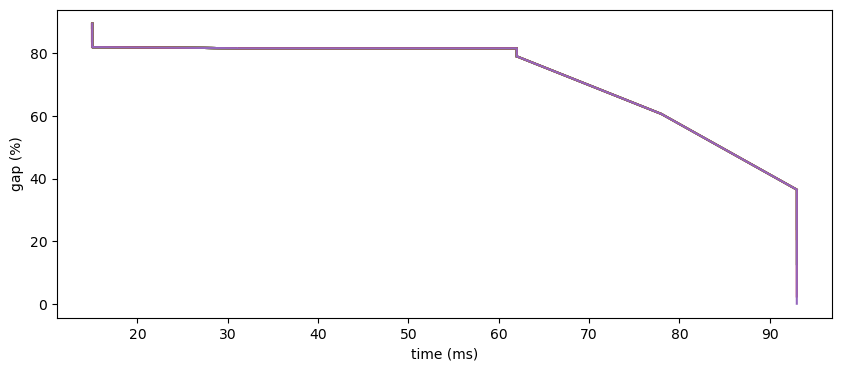

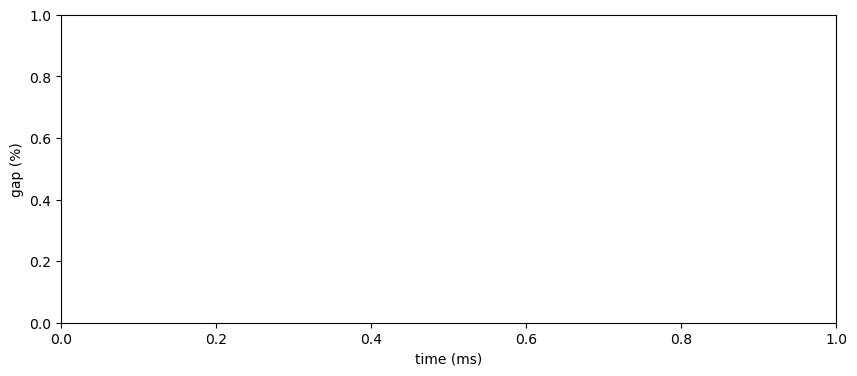

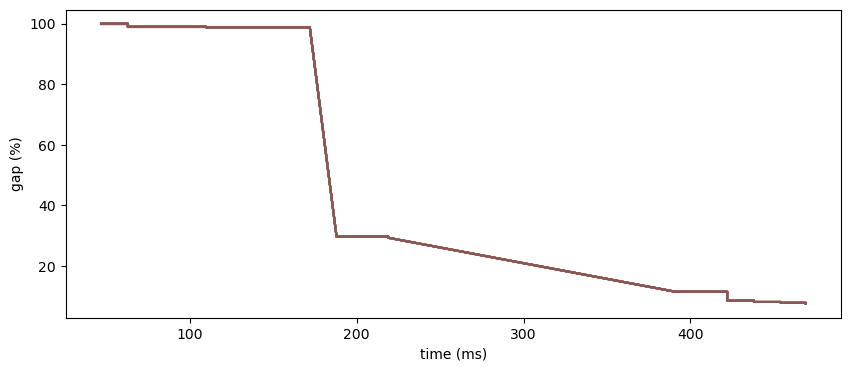

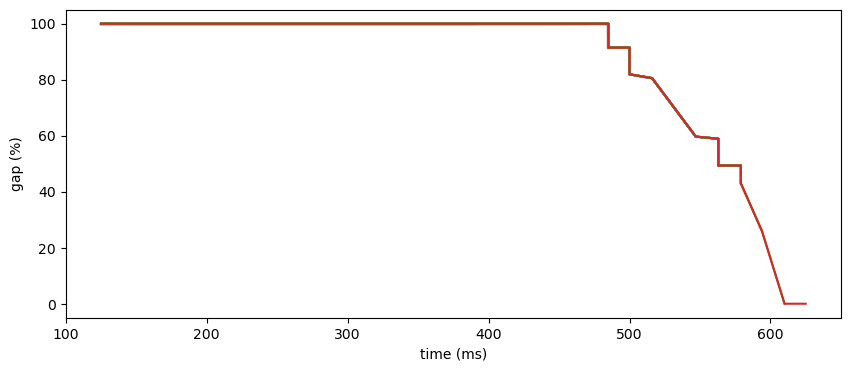

In [249]:
# file_name = f"./Data/airland{i}.txt"
R = [1, 2] 

for i in range(7, 9):
    for j in R:
        mdl_ = MIP_model(f"./Data/airland{i}.txt", j)
        mdl_.report()
        mdl_.print_solution()
        print(mdl_.solve_details)

## The CP model

In [10]:
def read_datafiles_cp(file):
    with open(file, 'r') as data:
        data_lines = data.readlines()
        number_planes = int(data_lines[0].split()[0])
        freeze_time =  int(data_lines[0].split()[1])
        mixed_data = [line.split() for line in data_lines[1:] if not line.isspace()]
        mixed_data = [[(float(j)) for j in i] for i in mixed_data]
        
        flight_details = np.empty([0,6],dtype=float)
        separation_time = np.empty([0,number_planes],dtype=float)
        
        flag = 0
       
        for element in mixed_data:
            if flag == 0: # flight details
                flight_details = np.vstack([flight_details, np.array(element)])
                flag = 1
                element_final = []
            else:  # separation_times
                element_final.extend(element)
                if len(element_final) == number_planes:
                    separation_time = np.vstack([separation_time, np.array(element_final)])
                    flag = 0

        minimum = min(flight_details[:,1])
        maximum = max(flight_details[:,3])
        num_periods = int(minimum % 10)
        int_size = (maximum-minimum)//num_periods #CT: Adicionei max-min
        period_constraints = []

        x = (0,0)
        lst = list(x)
        for i in range(num_periods-1): #CT: Adicionei -1 
            lst[0], lst[1] = int_size * i, int_size * (i+1)
            x = tuple(lst)
            period_constraints.append(x)

                
        print(f" number planes: {number_planes}")
        print(f" num_periods: {num_periods}")
        print(f" flight details: {flight_details}")
        print(f" period_constraints: {period_constraints}")
    
    return number_planes, num_periods, flight_details, separation_time, period_constraints #CT:added separation time

In [11]:
read_datafiles_cp("./Data/airland1.txt")

 number planes: 10
 num_periods: 9
 flight details: [[ 54. 129. 155. 559.  10.  10.]
 [120. 195. 258. 744.  10.  10.]
 [ 14.  89.  98. 510.  30.  30.]
 [ 21.  96. 106. 521.  30.  30.]
 [ 35. 110. 123. 555.  30.  30.]
 [ 45. 120. 135. 576.  30.  30.]
 [ 49. 124. 138. 577.  30.  30.]
 [ 51. 126. 140. 573.  30.  30.]
 [ 60. 135. 150. 591.  30.  30.]
 [ 85. 160. 180. 657.  30.  30.]]
 period_constraints: [(0.0, 72.0), (72.0, 144.0), (144.0, 216.0), (216.0, 288.0), (288.0, 360.0), (360.0, 432.0), (432.0, 504.0), (504.0, 576.0)]


(10, 9, array([[ 54., 129., 155., 559.,  10.,  10.],
        [120., 195., 258., 744.,  10.,  10.],
        [ 14.,  89.,  98., 510.,  30.,  30.],
        [ 21.,  96., 106., 521.,  30.,  30.],
        [ 35., 110., 123., 555.,  30.,  30.],
        [ 45., 120., 135., 576.,  30.,  30.],
        [ 49., 124., 138., 577.,  30.,  30.],
        [ 51., 126., 140., 573.,  30.,  30.],
        [ 60., 135., 150., 591.,  30.,  30.],
        [ 85., 160., 180., 657.,  30.,  30.]]), array([[9.9999e+04, 3.0000e+00, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [3.0000e+00, 9.9999e+04, 1.5000e+01, 1.5000e+01, 1.5000e+01,
         1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01, 1.5000e+01],
        [1.5000e+01, 1.5000e+01, 9.9999e+04, 8.0000e+00, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00, 8.0000e+00],
        [1.5000e+01, 1.5000e+01, 8.0000e+00, 9.9999e+04, 8.0000e+00,
         8.0000e+00, 8.0000e+00, 8.0000e+00, 8

In [56]:
from docplex.cp.model import CpoModel

def CP_model(file_name, R):
    # Create a new model
    mdl = CpoModel()

    P, freeze_time, flight_details, separation_time = read_datafiles(file_name)

    # The first column relates to the actual appearence time of the plane so will not be taken into account for our decision variables
    E = flight_details[:,1]  # earliest landing time
    T = flight_details[:,2]  # target landing time
    L = flight_details[:,3]  # latest landing time
    g = flight_details[:,4]  # penalty cost per unit of time for landing before target
    h = flight_details[:,5]  # penalty cost per unit of time for landing after target
    range_LT = max(flight_details[:,3]) - min(flight_details[:,1])  # landing range time

    s = separation_time  # here we consider separation time between planes that land in different runways, fundamentally their value is the same as the separation time matrix but in constraints it should be multiplied by the binary variable that says if the planes land in the same runway or not

    ij = [(i,j) for i in np.arange(P) for j in np.arange(P)]  # indexes for plane i and j landing in the same runway
    ir = [(i, r) for i in np.arange(P) for r in np.arange(R)]  # indexes for plane i landing in runway r

    # Creating the time spaces
    W = []
    V = []
    U = []
    for i in np.arange(P):
      for j in np.arange(P):
        if i != j:
          min_range_i, min_range_j, max_range_i, max_range_j = E[i], E[j], L[i], L[j]
          land_range_i = [min_range_i, max_range_i]
          land_range_j = [min_range_j, max_range_j]

          overlap = max(0, min(land_range_i[1], land_range_j[1]) - max(land_range_i[0], land_range_j[0]))  # Check if landing intervals overlap

          # To confirm if the separation time window is safe we should see if latest landing time of plane i plus the separation time
          # between plane i and j is lower and then the earliest landing time for plane j

          # This way we are also confirming that i lands before j

          if (overlap == 0) and ((L[i] + separation_time[i,j]) < E[j]):  # confirm that the windows don't intersept and separation time is big enough
            W.append((i,j))
          else:
            if (L[i] < E[j]):  # windows intersept but we know that i lands before j
              V.append((i,j))
            else:
              U.append((i,j))  # we don't know the order in which one lands
        else:
          continue

    # Defining decision variables

    alpha = mdl.integer_var_list(P, 0, int(max(L)), name="alpha")  # how soon a plane lands before target time
    beta  = mdl.integer_var_list(P, 0, int(max(L)), name="beta")  # how soon a plane lands after target time
    x = [mdl.integer_var(int(E[i]), int(L[i]), name="x_{}".format(i)) for i in np.arange(P)]  # landing time for a plane

    #sigma = mdl.binary_var_list(P, name="sigma")  # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    sigma = {}
    for i, j in ij:
      sigma[i, j] = mdl.binary_var(name="sigma_{}_{}".format(i, j)) # binary variable: 1 if plane i lands before plane j, 0 elsewhere
    y = {}
    for i, r in ir:
      y[i, r] = mdl.binary_var(name="y_{}_{}".format(i, r))# 1 if plane i lands on runway  r , 0 otherwise
    
    z = {}
    for i, j in ij:
      z[i, j] = mdl.binary_var(name="z_{}_{}".format(i, j))# 1 if plane i lands on runway  r , 0 otherwise

    # Defining constraints
    for i in np.arange(P):
      mdl.add(x[i] >= E[i]) # Const 1 - Landing time of plane i must be later than the earliest landing time
      mdl.add(x[i] <= L[i]) # Const 1 - Landing time of plane i must be earlier than the before latest landing time
      mdl.add(alpha[i] >= T[i] - x[i]) # Const 14 - How soon plane i lands before T[i] must be larger than T[i] - x[i]
      mdl.add(alpha[i] <= T[i] - E[i]) # Const 15 - How soon plane i lands before T[i] must be smaller than T[i] - E[i]
      mdl.add(alpha[i] >= 0) # Const 15 - How soon plane i lands before T[i] must be at least zero
      mdl.add(beta[i] >= x[i] - T[i])  # Const 16 - How soon plane i lands after T[i] must be larger than x[i] - T[i]
      mdl.add(beta[i] <= L[i] - T[i])  # Const 17 - How soon plane i lands after T[i] must be smaller than L[i] - T[i]
      mdl.add(beta[i] >= 0)  # Const 17 - How soon plane i lands after T[i] must be at least zero
      mdl.add(x[i] == T[i] - alpha[i] + beta[i])  # Const 18 - Landing time is equal to target time minus arriving early or plus arriving late

    # Const 2 - Plain i must land before plain j or plain j before plain i
    for i in range(P):
      for j in range(P):
        if i != j:
          mdl.add(sigma[i,j] + sigma[j,i] == 1)
    
    # Const 6 - If plane i lands before j we know that they belong in subspace W or V 
    for i in range(P):
      for j in range(P):
        if ((i,j) in V) or ((i,j) in W):
          mdl.add(sigma[i,j] == 1)
          
    # Const 12 - Separation time between plane i and plane j must be respected
    for i in range(P):
      for j in range(P):
        if (i and j) in U:
          mdl.add(x[j] >= (x[i] + (separation_time[i,j]*sigma[i,j]) - ((L[i] - E[j])*sigma[j,i])))  
    
    # Const 28 - Plane i can only land in 1 runaway
    for i in np.arange(P):
        mdl.add(mdl.sum([y[i, r] for r in np.arange(R)]) == 1) 

    # Const 29 - Symetry constraint: If plane i lands in the same runaway as plane j, plane j lands in the same runaway as plane i
    for i in np.arange(P):
      for j in np.arange(P):
        if j > i:
          mdl.add(z[i,j]==z[j,i]) 

    # Const 30 - If there is any runaway r for which y[i,r]=y[j,r]=1 then z[i,j]=1. If z[i,j]=0 then the planes i and j cannot land on the same runaway 
    for i in np.arange(P):
      for j in np.arange(P):
        for r in np.arange(R):
          if j > i:
            mdl.add(z[i,j] >= y[i,r] + y[j,r]-1)

    # Const 31 - Landing times should respect separation times considering if they land in the same runway or not in subspace V
    for i in range(P):
      for j in range(P):
        if (i,j) in V:
          mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j])))

    # Const 33 - Landing times should respect separation times considering if they land in the same runway or not in subspace U
    for i in range(P):
      for j in range(P):
        if (i and j) in U:
          mdl.add(x[j] >= (x[i] + separation_time[i,j]*z[i,j] + s[i,j]*(1-z[i,j] - (L[i] + max(separation_time[i,j], s[i,j]) - E[j])*sigma[j,i])))
    # Objective function
    mdl.minimize(mdl.sum(g[i] * alpha[i] + h[i] * beta[i] for i in np.arange(P)))

    # Solve model
    solution = mdl.solve()

    # Print solution
    for i in range(P):
      print("Plane {} lands at {}".format(i, solution.get_var_solution(x[i])))


In [57]:
file_name = "./Data/airland2.txt"
R = 2
CP_model(file_name, R)

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 495 variables, 675 constraints
 ! Presolve      : 210 extractables eliminated
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 677.4 (before), 677.4 (after)
 !  . Memory usage      : 574.4 kB (before), 574.4 kB (after)
 ! Using parallel search with 2 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        495                 -
 + New bound is 0
 *             0      163  0.03s        1      (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 0 (optimal - effective tol. is 0)
 ! Best bound             : 0
 ! ----------------------------------------------------------------------------
 ! Number of bra